In [2]:
#!pip install transformers
#!pip install datasets
#!pip install tensorflow
#!pip install matplotlib
#!pip install seaborn

In [3]:
from datasets import load_dataset,DatasetDict
from transformers import AutoTokenizer,TFAutoModelForSequenceClassification
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

2023-04-14 11:04:20.047408: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-14 11:04:26.488479: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-14 11:04:26.488497: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-04-14 11:04:33.739834: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [6]:
##importing dataset
DATA_PATH = "/home/aaditya/Project/CBDe-Using-BERT/Bert Training/labeled_data.csv" 

In [7]:
pandas_df = pd.read_csv(DATA_PATH)

pandas_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


<Axes: xlabel='class', ylabel='count'>

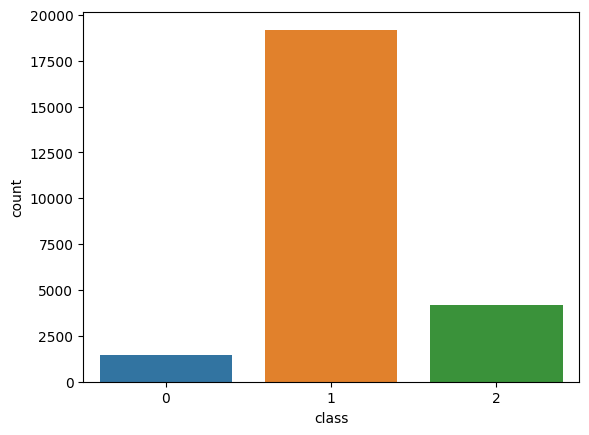

In [8]:
import seaborn as sns

sns.countplot(x='class', data=pandas_df)

In [9]:
pandas_df['tweet_cleaned'] = pandas_df['tweet'].str.replace('@[A-Za-z0-9]+\s?', '', regex=True)
pandas_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet,tweet_cleaned
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...,!!! RT : As a woman you shouldn't complain abo...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...,!!!!! RT : boy dats cold...tyga dwn bad for cu...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...,!!!!!!! RT Dawg!!!! RT : You ever fuck a bitch...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...,!!!!!!!!! RT _G_Anderson: _based she look like...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...,!!!!!!!!!!!!! RT : The shit you hear about me ...


In [10]:
from datasets import Dataset

ds = Dataset.from_pandas(pandas_df)
ds

Dataset({
    features: ['Unnamed: 0', 'count', 'hate_speech', 'offensive_language', 'neither', 'class', 'tweet', 'tweet_cleaned'],
    num_rows: 24783
})

In [11]:
train_test_valid = ds.train_test_split()

test_valid = train_test_valid['test'].train_test_split()

train_test_valid_dataset = DatasetDict({
    'train': train_test_valid['train'],
    'test': test_valid['test'],
    'valid': test_valid['train']
    })


dataset = train_test_valid_dataset.remove_columns(['hate_speech', 'offensive_language', 'neither','Unnamed: 0', 'count'])
dataset

DatasetDict({
    train: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 18587
    })
    test: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 1549
    })
    valid: Dataset({
        features: ['class', 'tweet', 'tweet_cleaned'],
        num_rows: 4647
    })
})

In [12]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased")


In [13]:
text = "Just checking tokenization"

output = tokenizer(text)

output

{'input_ids': [101, 2066, 9444, 22559, 2734, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1]}

In [14]:
tokens = tokenizer.convert_ids_to_tokens(output['input_ids'])
tokens

['[CLS]', 'Just', 'checking', 'token', '##ization', '[SEP]']

In [15]:
print(f"Tokenized text: {tokenizer.convert_tokens_to_string(tokens)}")


Tokenized text: [CLS] Just checking tokenization [SEP]


In [16]:
print(f"Vocab size is : {tokenizer.vocab_size}")

print(f"Model max length is : {tokenizer.model_max_length}")

print(f"Model input names are: {tokenizer.model_input_names}")

Vocab size is : 28996
Model max length is : 512
Model input names are: ['input_ids', 'token_type_ids', 'attention_mask']


In [17]:
def tokenize_function(train_dataset):
    return tokenizer(train_dataset['tweet_cleaned'], padding='max_length', truncation=True) 


tokenized_dataset = dataset.map(tokenize_function, batched=True)

tokenized_dataset

train_dataset = tokenized_dataset['train']
eval_dataset = tokenized_dataset['valid']
test_dataset = tokenized_dataset['test']

Map:   0%|          | 0/18587 [00:00<?, ? examples/s]

Map:   0%|          | 0/1549 [00:00<?, ? examples/s]

Map:   0%|          | 0/4647 [00:00<?, ? examples/s]

In [18]:
train_dataset

Dataset({
    features: ['class', 'tweet', 'tweet_cleaned', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 18587
})

In [19]:
train_set = train_dataset.remove_columns(['tweet','tweet_cleaned']).with_format('tensorflow')

tf_eval_dataset = eval_dataset.remove_columns(['tweet','tweet_cleaned']).with_format('tensorflow')

tf_test_dataset = test_dataset.remove_columns(['tweet','tweet_cleaned']).with_format('tensorflow')

In [ ]:
train_features = { x: train_set[x] for x in tokenizer.model_input_names  }

train_set_for_final_model = tf.data.Dataset.from_tensor_slices((train_features, train_set['class'] ))

train_set_for_final_model = train_set_for_final_model.shuffle(len(train_set)).batch(8)


eval_features = {x: tf_eval_dataset[x] for x in tokenizer.model_input_names}
val_set_for_final_model = tf.data.Dataset.from_tensor_slices((eval_features, tf_eval_dataset["class"]))
val_set_for_final_model = val_set_for_final_model.batch(8)

test_features = {x: tf_test_dataset[x] for x in tokenizer.model_input_names}
test_set_for_final_model = tf.data.Dataset.from_tensor_slices((test_features, tf_test_dataset["class"]))
test_set_for_final_model =test_set_for_final_model.batch(8)

In [21]:
model = TFAutoModelForSequenceClassification.from_pretrained("bert-base-cased", num_labels=3)
# model = TFAutoModelForSequenceClassification.from_pretrained("/mnt/e0ccdbdb-22c3-4d9b-9413-fd976a2e99ae/M1/Code_Org/HF_Models/bert-base-uncased", num_labels=3)


model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=tf.metrics.SparseCategoricalAccuracy(),
)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [1]:
history = model.fit(train_set_for_final_model, validation_data=val_set_for_final_model, epochs=3 )


NameError: name 'model' is not defined